In [1]:
import csv
import datetime
import operator
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import load_house

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

# Create directory for matplotlib figures
if not os.path.exists('plot/qry_pot_channel'):
    os.makedirs('plot/qry_pot_channel')
if not os.path.exists('plot/qry_total_cons_channel'):
    os.makedirs('plot/qry_total_cons_channel')
if not os.path.exists('plot/qry_total_cons_all'):
    os.makedirs('plot/qry_total_cons_all')

In [2]:
channels, labels = load_house.SMART('2016')

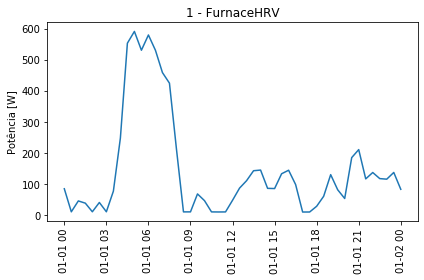

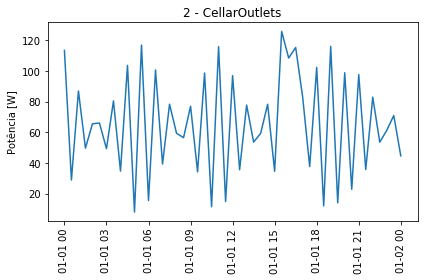

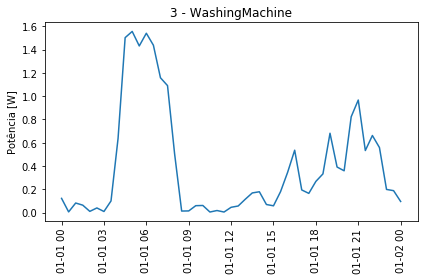

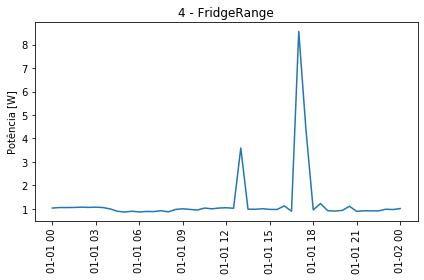

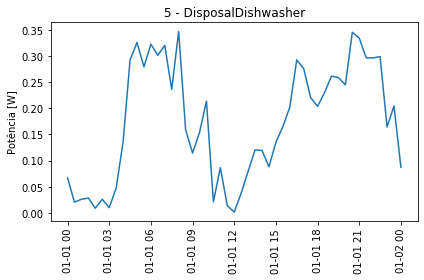

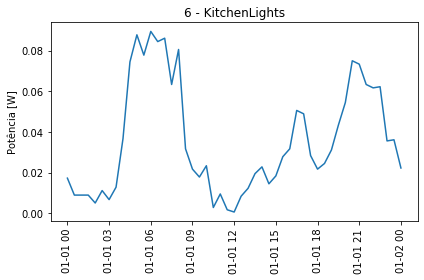

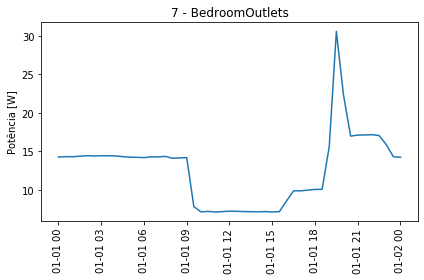

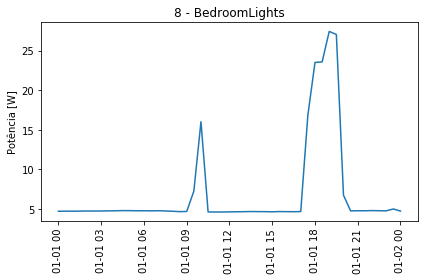

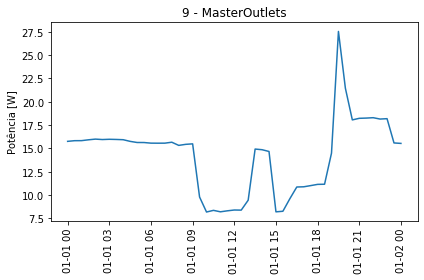

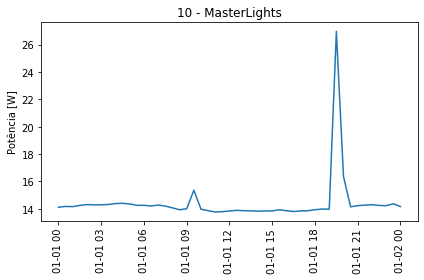

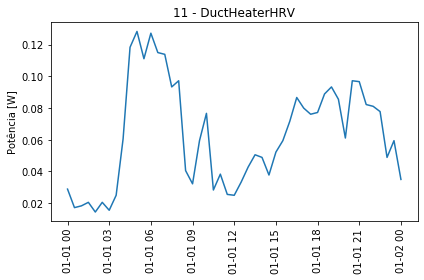

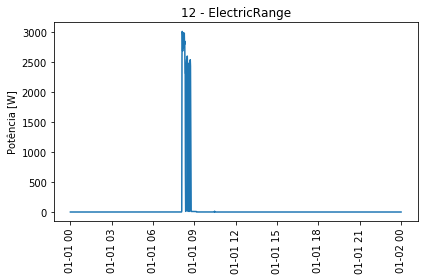

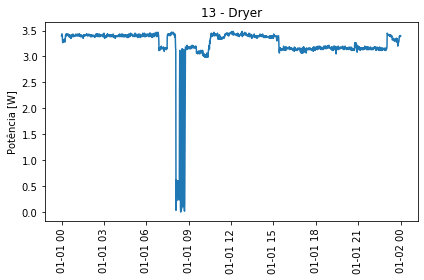

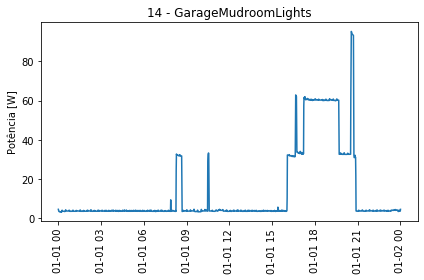

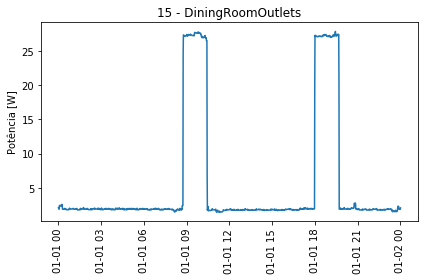

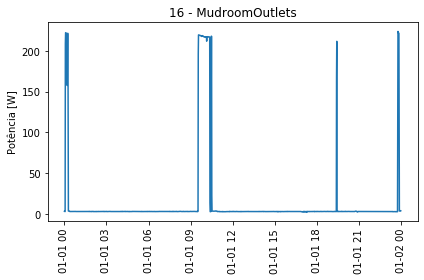

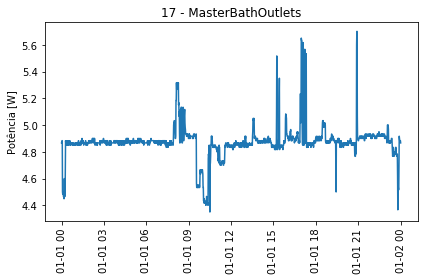

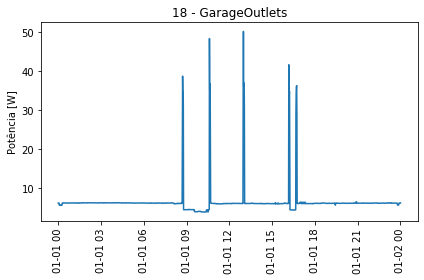

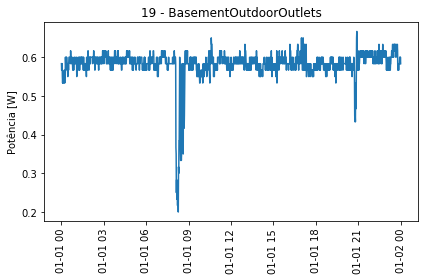

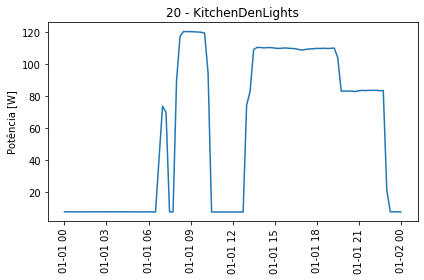

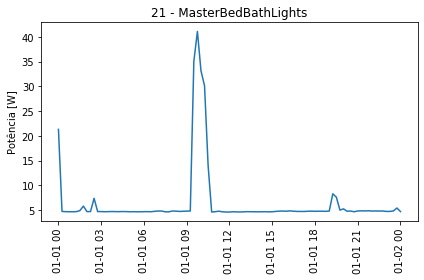

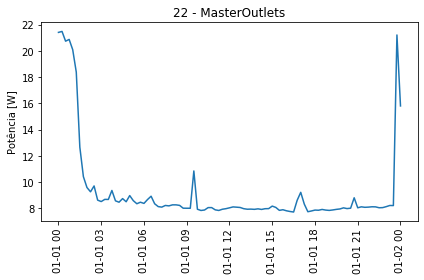

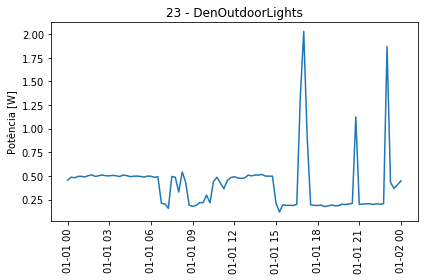

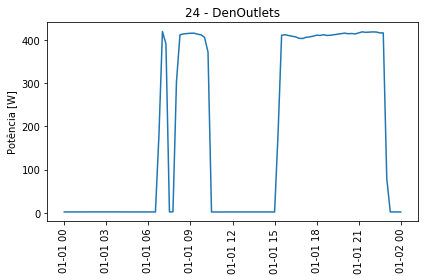

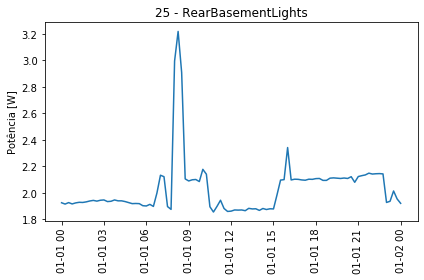

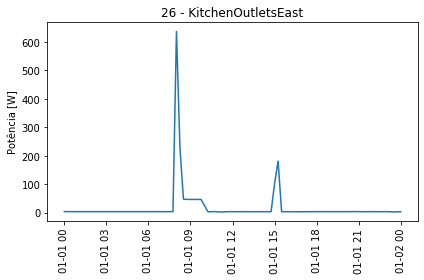

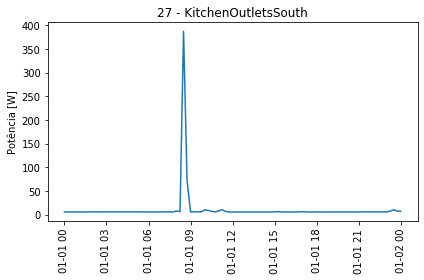

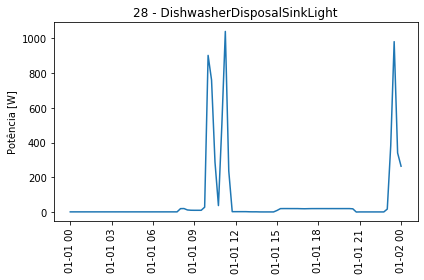

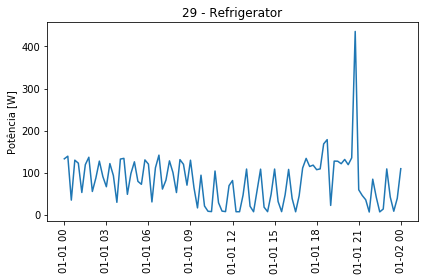

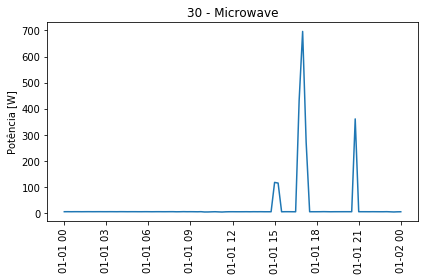

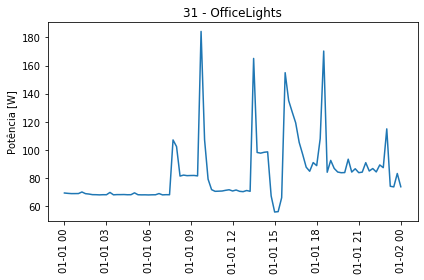

In [3]:
def qry_pot_channel(i_channel, start, end):
    """Runs a query for the potency consumption in a channel in the specified period.
    
    Args:
        i_channel(int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
    
    Returns:
        str: csv of the query as [index, time, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 0-{}. The value was {}'.format(len(labels) - 1, i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Return query as csv string
    return ch_period.to_csv()


# Plot data from day 2016-01-01
for i in range(len(channels)):
    query = qry_pot_channel(i, '2016-01-01', '2016-01-02 00:00:05')
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    plt.plot(ch.t, ch.pot)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Potência [W]')
    plt.xticks(rotation=90)
    plt.savefig('plot/qry_pot_channel/channel_{}.png'.format(i + 1))
    plt.show()

In [ ]:
def qry_total_cons_channel(i_channel, start, end, frequency):
    """Runs a query for the total consumption in a channel in the specified period.
    
    Args:
        i_channel (int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 1-{}. The value was {}'.format(len(labels), i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Find mean consumption by day, week, or month
    cons = ch_period.copy()
    cons = cons.set_index('t')
    cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
    cons = cons.reset_index()
    cons = pd.concat([cons.t, cons.pot], axis=1)
    cons.columns = ['t', 'energy']
    
    # Remove days without consumption data
    cons = cons[~cons.energy.isna()]
    
    # Convert to kWh
    period_hours = 24
    if frequency == 'W':
        period_hours *= 7
    if frequency == 'M':
        period_hours *= 30
    cons.energy = cons.energy * period_hours / 1e3
    
    # Return query as csv string
    return cons.to_csv()


# Plot daily consumption for each channel for all period available
day_cons = []

for i in range(len(channels)):
    query = qry_total_cons_channel(i, '2016-01-01', '2016-12-31', 'W')
    
    cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    cons.t = pd.to_datetime(cons.t)
    
    day_cons.append(cons)
    plt.plot(cons.t, cons.energy)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Consumo [kWh]')
    plt.xticks(rotation=90)
    plt.savefig('plot/qry_total_cons_channel/channel_{}.png'.format(i + 1))
    plt.show()

In [ ]:
def qry_total_cons_all(start, end, percentage=False):
    """Runs a query for the total consumption in each channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        percentage (bool): if true, return percentage of total consumption of each channel.
    
    Returns:
        str: csv of the query as [label; total consumption].
    """
    total_cons = {}
    for i in range(0, len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]
        
        # Find mean consumption
        cons = ch_period.pot.mean()
        
        # Convert to kWh
        t1 = pd.to_datetime(start)
        t2 = pd.to_datetime(end)
        cons *= pd.Timedelta(t2 - t1).total_seconds() / (1e3 * 3600)
        
        # Add total consumption of channel i to hash map
        appliance_name = labels.iloc[i]['name']
        if appliance_name != 'mains':
            if appliance_name not in total_cons:
                total_cons[appliance_name] = cons
            else:
                total_cons[appliance_name + '_1'] = total_cons.pop(appliance_name)
                total_cons[appliance_name + '_2'] = cons
    
    if percentage == True:
        sum = 0
        for key, value in total_cons.items():
            sum += value
        for key, value in total_cons.items():
            total_cons[key] /= sum
    
    sorted_cons = sorted(total_cons.items(), key=operator.itemgetter(1), reverse=True)
    
    result = ','.join([item[0] for item in sorted_cons]) + '\n'
    result += ','.join([str(item[1]) for item in sorted_cons])
    return result


start_date = pd.to_datetime('2016-01-01')
end_date = start_date + pd.to_timedelta('30 days')
query = qry_total_cons_all(start_date, end_date, percentage=True)

f = StringIO(query)
qry_reader = csv.reader(f, delimiter=',')
sorted_cons = []
for row in qry_reader:
    sorted_cons.append(row)

for i in range(len(sorted_cons[1])):
    sorted_cons[1][i] = float(sorted_cons[1][i])

max_channels = 8
sum_others = 0
for i in range(max_channels, len(sorted_cons[1])):
    sum_others += sorted_cons[1][i]

sorted_cons[0] = sorted_cons[0][:max_channels] + ['Outros']
sorted_cons[1] = sorted_cons[1][:max_channels] + [sum_others]

cmap = plt.cm.Set3
colors = cmap(np.linspace(0., 1., len(sorted_cons[0])))

fig1, ax1 = plt.subplots()

explode = [0.05] * (max_channels + 1)

#plt.figure(figsize=(100, 100))
plt.title('Consumo (%) de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
ax1.pie(sorted_cons[1], labels=sorted_cons[0], startangle=90, counterclock=False, autopct='%.1f', colors=colors,
       pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.show()

plt.savefig('plot/qry_total_cons_all/by_channel.png')